# Pricing Impacts from 6/14 Increases

In [345]:
# libraries
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(RPostgreSQL))
suppressMessages(library(RcppRoll))
suppressMessages(library(stringr))
suppressMessages(library(gridExtra))
suppressMessages(library(repr))
suppressMessages(library(clipr))
suppressMessages(library(MarketMatching))
suppressMessages(library(config))

In [271]:
# setting wd
if ( grepl("june-14-pricing-impacts", getwd(), fixed = TRUE) ) {
    print("current working directory is fine")
} else {
    setwd("./projects/pricing/june-14-pricing-impacts/")
    print("changed working directory")
}

[1] "current working directory is fine"


In [272]:
# load functions
source("functions.R")

### Get Data

In [273]:
dw <- config::get(file="./redshift_credentials.yml")

In [274]:
con <- DBI::dbConnect(RPostgreSQL::PostgreSQL(),
                      dbname = dw$dbname,
                      host = dw$host,
                      port = dw$port,
                      user = dw$user,
                      password = dw$password)

In [275]:
options(warn=-1)
query_sales   <- getSQL("sql/data_pull__sales.sql")
query_spend   <- getSQL("sql/data_pull__spend.sql")
query_traffic <- getSQL("sql/data_pull__traffic.sql")
options(warn=0)

In [276]:
options(warn=-1)
df_sales   <- dbGetQuery(con, query_sales) %>% as_tibble()
df_spend   <- dbGetQuery(con, query_spend) %>% as_tibble()
df_traffic <- dbGetQuery(con, query_traffic) %>% as_tibble()
options(warn=0)

### Measure Incrementality

In [307]:
# parameters
measurement_start_date <- as_date("2021-10-12")
target_category <- '5x7_Classic System_non-licensed'
target_function <- 'Indoor'
group_by_fields <- c("size", 
                     "product_sub_type", 
                     "rug_collection")

In [346]:
# group sales data
df_sales_grouped <- groupData(df_sales %>% 
                                  filter(`function`==target_function) %>%
                                  unite(group_by_col, all_of(group_by_fields)),
                              c("date","group_by_col"))
#df_sales_grouped <- df_sales_grouped %>% mutate(size_select_group = paste0(size,"_",select_group))

In [347]:
# get best time series controls
ts_controls <- getControls(data = df_sales_grouped,
                           id_var = "group_by_col",
                           start_date="2021-01-01",
                           end_date = "2021-09-30",
                           target_var = target_category)

# put ts controls in list
list_of_controls <- list()
for (i in 1:nrow(ts_controls %>% select(BestControl))) {
    ts_control_name <- ts_controls %>% select(BestControl) %>% slice(i) %>% as.character()
    list_of_controls[[paste0("ts_control_",ts_control_name)]] <- df_sales_grouped %>%
        filter(group_by_col == ts_control_name) %>%
        select(date, quantity)
}

# join ts controls to df_sales_grouped
for (i in 1:nrow(ts_controls %>% select(BestControl))) {
    ts_name <- ts_controls %>% select(BestControl) %>% slice(i) %>% as.character() %>% str_replace_all(c("\"" = "", " " = ""))
    df_sales_grouped <- df_sales_grouped %>%
        left_join(list_of_controls[[i]], by="date",
                  suffix = c("", paste0("_",ts_name)))
}

# joining df and xreg
df_w_xreg <- df_sales_grouped %>%
    left_join(df_traffic, by="date") %>%
    inner_join(df_spend, by=c("date"), suffix=c("","_ignore")) %>%
    mutate(dow = as.factor(wday(date)))

In [349]:
names(df_w_xreg)

[1] "date"            "group_by_col"    "quantity"        "num_sessions"   
 [5] "total_spend"     "fb_spend"        "google_spend"    "pinterest_spend"
 [9] "bing_spend"      "dow"

In [348]:
print(names(df_w_xreg)[4:(length(names(df_w_xreg))-7)])

[1] "num_sessions" "quantity"    


In [322]:
#options(warn=-1)
# split train and test
df_all <- df_w_xreg %>%
    filter(group_by_col == target_category) %>%
    as_tsibble(index = date, key = group_by_col) %>%
    fill_gaps(quantity = 0L) %>%
    filter(date < measurement_start_date + 100)
df_train <- df_all %>%
    filter(date < measurement_start_date)
df_test <- df_all %>%
    filter(date >= measurement_start_date)

# fit model
fit <- df_train %>%
    model(arima = ARIMA(log(quantity+1) ~
                        # for 5x7 Classic Non-Licensed
                        #`quantity_3x5_ClassicSystem_non-licensed` +
                        #`quantity_2.5x7_ClassicSystem_non-licensed` +
                        `quantity_2x3_ClassicSystem_non-licensed` +
                        # for 6x9, 8x10, & 9x12 Cushioned Licensed
                        #`quantity_2.5x10_CushionedSystem_licensed` +
                        #`quantity_6Round_ClassicSystem_licensed` +
                        # for 6x9, 8x10, & 9x12 Classic Licensed
                        # use ETS(log(quantity + 1)) and remove all xreg
                        # for 8x10 Cushioned Non-Licensed
                        #`quantity_2.5x10_CushionedSystem_non-licensed` +
                        #`quantity_3x5_CushionedSystem_non-licensed` +
                        #`quantity_6Round_ClassicSystem_non-licensed` +
                        # for 6x9 Cushioned Non-Licensed
                        #`quantity_6Round_ClassicSystem_non-licensed` + 
                        #`quantity_2.5x10_CushionedSystem_non-licensed` +
                        # for 9x12 Classic Non-Licensed
                        #`quantity_2.5x7_CushionedSystem_non-licensed` +
                        #`quantity_3x5_CushionedSystem_non-licensed` +
                        #`quantity_2.5x10_CushionedSystem_non-licensed` +
                        # for 6x9 & 8x10 Classic Non-Licensed
                        #`quantity_2.5x10_ClassicSystem_non-licensed` +
                        #`quantity_2.5x7_ClassicSystem_non-licensed` +
                        #`quantity_3x5_ClassicSystem_non-licensed` +
                        # for 8x10 Classic Non-Licensed
                        #`quantity_2.5x10_ClassicSystem_non-licensed` +
                        #`quantity_2.5x7_ClassicSystem_non-licensed` +
                        #`quantity_5x7_ClassicSystem_non-licensed` +
                        # for 9x12 Classic Non-Licensed
                        #`quantity_2.5x7_CushionedSystem_non-licensed` +
                        #`quantity_3x5_CushionedSystem_non-licensed` +
                        #`quantity_5x7_CushionedSystem_non-licensed` +
                        # for 6x9 Classic Non-Licensed
                        #`quantity_2.5x10_ClassicSystem_non-licensed` +
                        #`quantity_5x7_ClassicSystem_non-licensed` +
                        #`quantity_2.5x7_ClassicSystem_non-licensed` +
                        # for 8x10 Cushioned Non-Licensed
                        #`quantity_5x7_CushionedSystem_non-licensed` +
                        #`quantity_2.5x10_CushionedSystem_non-licensed` +
                        #`quantity_3x5_CushionedSystem_non-licensed` +
                        # for 8x10 Classic Licensed
                        # use ETS(log(quantity + 1)) and remove all xreg
                        # for 9x12 Classic Licensed
                        # use ETS(log(quantity + 1)) and remove all xreg
                        # for 6x9 Classic Licensed
                        #quantity_2.5x10_ClassicSystem_licensed +
                        #quantity_5x7_CushionedSystem_licensed +
                        #quantity_2.5x7_ClassicSystem_licensed +
                        # for 6x9 Classic Licensed
                        #quantity_2.5x10_CushionedSystem_licensed +
                        #quantity_6Round_ClassicSystem_licensed +
                        #quantity_3x5_CushionedSystem_licensed +
                        # for 8 Round Cushioned Non-Licensed
                        # use ETS(log(quantity + 1)) and remove all xreg
                        # for 8 Round Classic Non-Licensed
                        #quantity_5x7_ClassicSystem_licensed +
                        #quantity_3x5_ClassicSystem_licensed +
                        # for 6 Round Classic Non-Licensed
                        #`quantity_2.5x10_CushionedSystem_non-licensed` +
                        #`quantity_5x7_CushionedSystem_non-licensed` +
                        # for 8 Round Cushioned Licensed
                        # use ETS(log(quantity + 1)) and remove all xreg
                        # for 8 Round Classic Licensed
                        # use ETS(log(quantity + 1)) and remove all xreg
                        # for 6 Round Classic Licensed
                        #quantity_2.5x10_CushionedSystem_licensed +
                        # for 8x10 Outdoor
                        #`quantity_2.5x7_ClassicSystem_non-licensed` +
                        #`quantity_2.5x10_ClassicSystem_non-licensed` +
                        # for 9x12 Outdoor
                        # used same xreg as 8x10 outdoor due to lack of historical data on 9x12 outdoor which is a recent launch
                        #`quantity_2.5x7_ClassicSystem_non-licensed` +
                        #`quantity_2.5x10_ClassicSystem_non-licensed` +
                        # for 6x9 Outdoor
                        #`quantity_2.5x7_ClassicSystem_non-licensed` +
                        #`quantity_2.5x10_ClassicSystem_non-licensed` +
                        total_spend +
                        num_sessions +
                        #trend() +
                        #season(period = 365) +
                        dow
                       ))

# create forecast
fc <- fit %>%
    forecast(new_data = df_test)
fc %>% accuracy(data = df_test)
#options(warn=0)

Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”


.model,group_by_col,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
arima,5x7_Classic System_non-licensed,Test,54.87959,94.23138,59.91386,5.660638,6.556414,NaN,NaN,-0.003486286


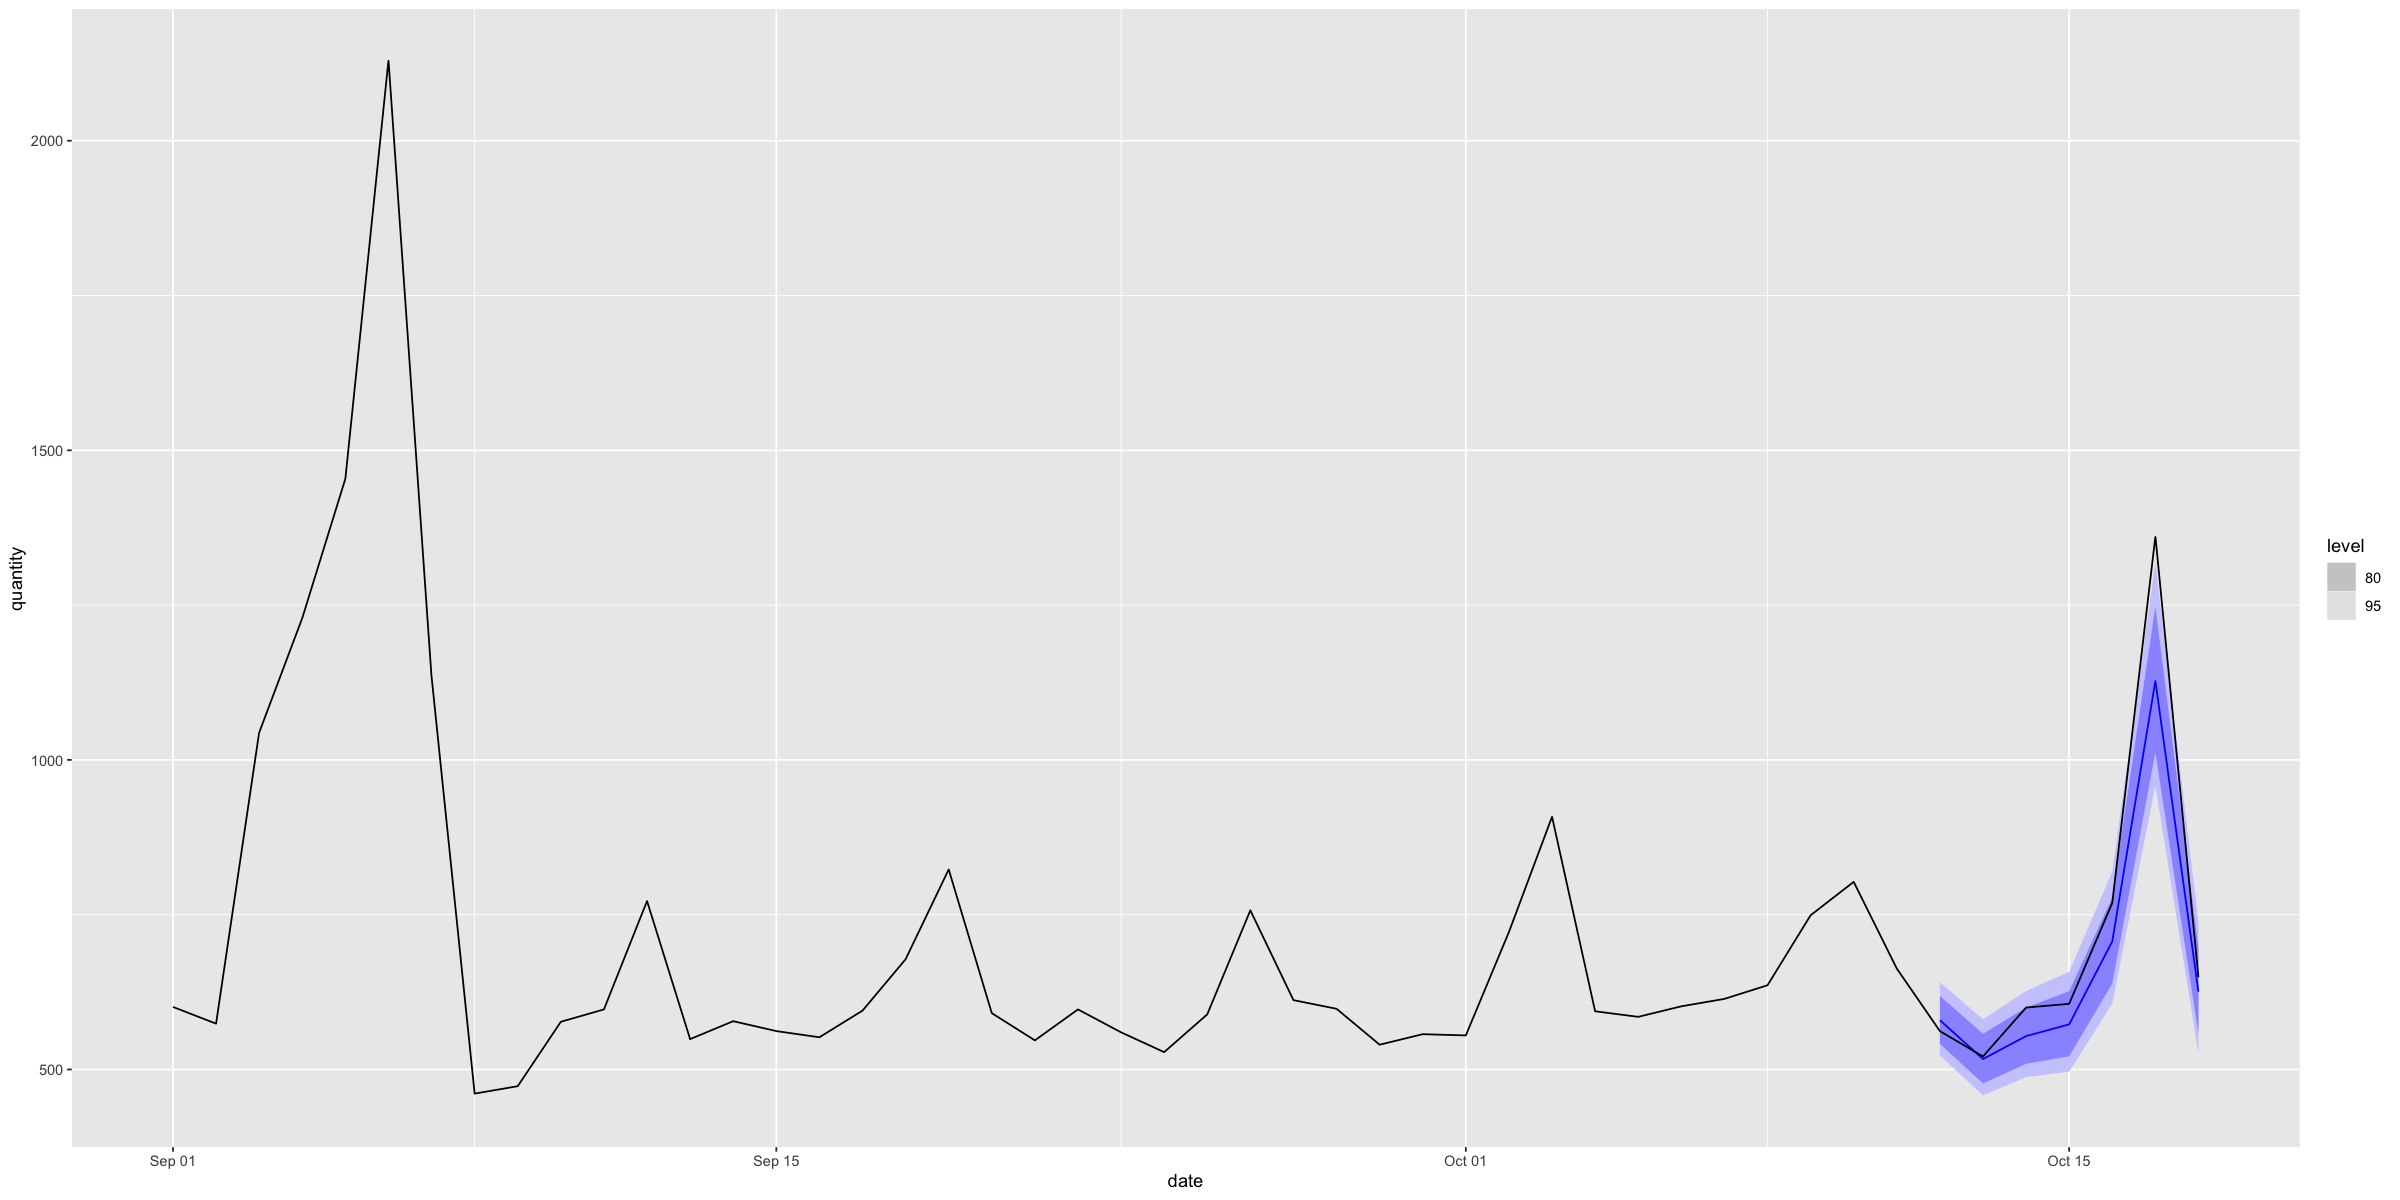

In [323]:
# plot actuals vx forecast
options(repr.plot.width=20, repr.plot.height=10) # define fig size
fc %>%
    autoplot(df_all %>% filter(date>=as_date("2021-09-01")))

In [324]:
fitted_values <- fit %>% 
    fitted() %>% 
    as_tibble() %>%
    select(date,.fitted) %>%
    rename(forecast = .fitted)

forecasted_values <- fc %>%
    as_tibble() %>%
    select(date,.mean) %>%
    rename(forecast = .mean)

write_clip(fitted_values %>%
               union(forecasted_values) %>%
               arrange(date) %>%
               filter(date >= as_date('2021-09-09')),
           allow_non_interactive = TRUE)

In [325]:
forecasted_values

date,forecast
<date>,<dbl>
2021-10-12,579.6199
2021-10-13,516.8633
2021-10-14,553.9100
2021-10-15,572.8285
2021-10-16,706.8597
2021-10-17,1127.2047
2021-10-18,625.5568


In [314]:
write_clip(df_all %>%
             as_tibble() %>%
             filter(group_by_col == target_category &
                    date >= as_date("2021-09-09")
                   ) %>%
             select(date, quantity),
           allow_non_interactive = TRUE)

### Scratch